# Veri temini

In [ ]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")  # 0=malignant, 1=benign (sklearn'de böyle)

df = X.copy()
df["target"] = y

df.shape
df["target"].value_counts()


(569, 31)

target
1    357
0    212
Name: count, dtype: int64

# EDA

In [5]:
df.describe().T.head(10)

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.98100,11.70000,13.37000,15.78000,28.11000
mean texture,569.0,19.289649,4.301036,9.71000,16.17000,18.84000,21.80000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.79000,75.17000,86.24000,104.10000,188.50000
mean area,569.0,654.889104,351.914129,143.50000,420.30000,551.10000,782.70000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.05263,0.08637,0.09587,0.10530,0.16340
mean compactness,569.0,0.104341,0.052813,0.01938,0.06492,0.09263,0.13040,0.34540
mean concavity,569.0,0.088799,0.079720,0.00000,0.02956,0.06154,0.13070,0.42680
mean concave points,569.0,0.048919,0.038803,0.00000,0.02031,0.03350,0.07400,0.20120
mean symmetry,569.0,0.181162,0.027414,0.10600,0.16190,0.17920,0.19570,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.04996,0.05770,0.06154,0.06612,0.09744


In [6]:
df["target"].value_counts(normalize=True).round(2)


target
1    0.63
0    0.37
Name: proportion, dtype: float64

# Modelleme

## Train/Test Ayrımı

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((426, 30), (143, 30))

## Preprocessing

## İlk model (overfitting)

### Eğitim ve tahminleme

In [8]:
tree_raw = DecisionTreeClassifier(random_state=42)
tree_raw.fit(X_train, y_train)

pred_tr = tree_raw.predict(X_train)
pred_te = tree_raw.predict(X_test)

print("Train Acc:", accuracy_score(y_train, pred_tr))
print("Test  Acc:", accuracy_score(y_test, pred_te))


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

Train Acc: 1.0
Test  Acc: 0.9230769230769231


In [9]:
def clf_metrics(y_true, y_pred, y_proba=None):
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        out["roc_auc"] = roc_auc_score(y_true, y_proba)
    return pd.Series(out)

proba_te = tree_raw.predict_proba(X_test)[:, 1]
display(clf_metrics(y_test, pred_te, proba_te))


accuracy     0.923077
precision    0.954023
recall       0.922222
f1           0.937853
roc_auc      0.923375
dtype: float64

In [10]:
cm = confusion_matrix(y_test, pred_te)
cm


array([[49,  4],
       [ 7, 83]])

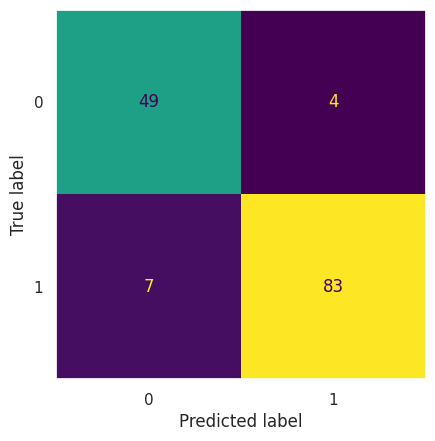

In [ ]:
ConfusionMatrixDisplay.from_estimator(tree_raw, X_test, y_test, colorbar=False)
plt.grid(False)

In [11]:
print(classification_report(y_test, pred_te, target_names=data.target_names))


              precision    recall  f1-score   support

   malignant       0.88      0.92      0.90        53
      benign       0.95      0.92      0.94        90

    accuracy                           0.92       143
   macro avg       0.91      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



### Görselleştirme

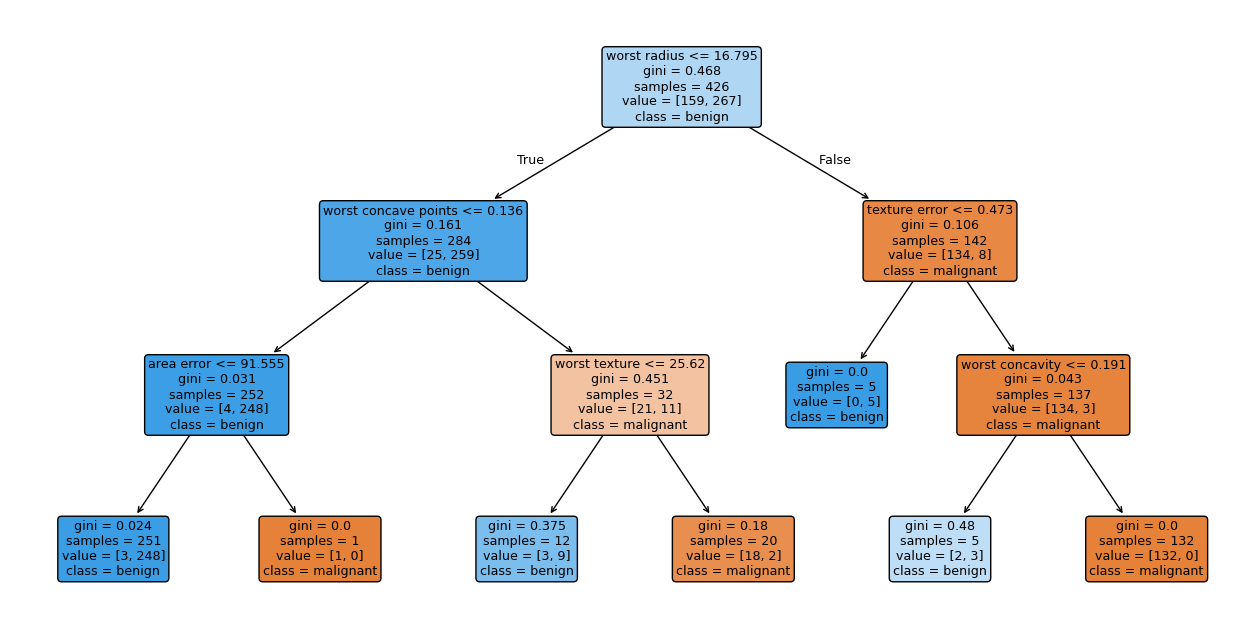

In [12]:
tree_shallow = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_shallow.fit(X_train, y_train)

plt.figure(figsize=(16, 8))
plot_tree(
    tree_shallow,
    feature_names=data.feature_names,
    class_names=data.target_names,
    filled=True,
    rounded=True,
    impurity=True
)
plt.show();


Kutuların içini okuyalım:

- **gini**: ilk node'da 0.468, orta saflıkta. ilk nodeoduğu için gini'nin yüksek çıkması normal. Sonrakilerde genelde düşüyor
- **samples**:  ilgili nodedaki sample sayısı. ilk nodeda 426, tüm eğitim seti. ikinci True nodunda 284, kalan 142 sağ node'da.
- **value**: sınıf sayılarıdır. ilk node'da 159 kötü huylu(malignant), 267 iyi huylu(benign)
- **class**: modelin bu node'daki kararı. ilk node'da iyi huylu kararı verilmiş, zira 267 ile iyiler çoğunlukta.

şimdi tek bir sample için karar yolu nasıl işlemiş onu görelim

In [13]:
idx = 0
x_one = X_test.iloc[[idx]]

node_indicator = tree_shallow.decision_path(x_one)
leaf_id = tree_shallow.apply(x_one)[0]

feature = tree_shallow.tree_.feature
threshold = tree_shallow.tree_.threshold

path_nodes = node_indicator.indices[node_indicator.indptr[0]: node_indicator.indptr[1]]

rules = []
for node_id in path_nodes:
    if node_id == leaf_id:
        continue
    f = feature[node_id]
    thr = threshold[node_id]
    fname = X.columns[f]
    val = x_one.iloc[0, f]
    if val <= thr:
        rules.append(f"{fname} <= {thr:.3f}  (değer={val:.3f})")
    else:
        rules.append(f"{fname} >  {thr:.3f}  (değer={val:.3f})")

print("\nKarar Yolu:")
for i, r in enumerate(rules, 1):
    print(f"{i}. {r}")



Karar Yolu:
1. worst radius <= 16.795  (değer=14.450)
2. worst concave points <= 0.136  (değer=0.080)
3. area error <= 91.555  (değer=28.620)


In [42]:
from mypyext import ml
features = X.columns
ml.tree_to_code(tree_shallow, features)

  if worst radius <= 16.795000076293945:
    if worst concave points <= 0.1359499990940094:
      if area error <= 91.55500030517578:
        return [[0.01195219 0.98804781]]
      else:  # if area error > 91.55500030517578
        return [[1. 0.]]
    else:  # if worst concave points > 0.1359499990940094
      if worst texture <= 25.619999885559082:
        return [[0.25 0.75]]
      else:  # if worst texture > 25.619999885559082
        return [[0.9 0.1]]
  else:  # if worst radius > 16.795000076293945
    if texture error <= 0.47314999997615814:
      return [[0. 1.]]
    else:  # if texture error > 0.47314999997615814
      if worst concavity <= 0.190700002014637:
        return [[0.4 0.6]]
      else:  # if worst concavity > 0.190700002014637
        return [[1. 0.]]


#### split görselleştirme

Verisetimiz çok boyutlu olduğu için ağacın sadece ilk split’lerinde kullanılan 2 feature’ı seçip,o split eşiklerini 2D grafikte çizdireceğiz.

In [28]:
f1 = "worst radius"
f2 = "worst concave points"
df_plot = df[[f1, f2, "target"]]


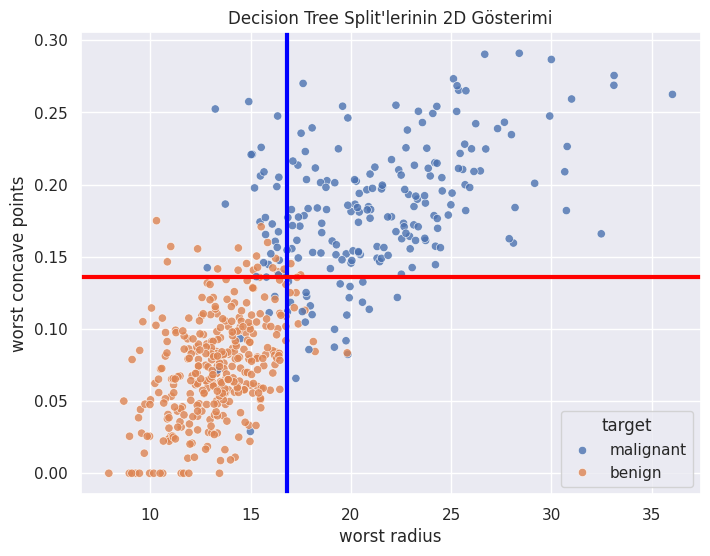

In [40]:
import seaborn as sns
sns.set(style="darkgrid")

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x=f1,
    y=f2,
    hue="target",
    alpha=0.8
)

# tree'den manuel okuduğumuzu varsayalım
thr_f1 = 16.8   # worst radius
thr_f2 = 0.136   # worst concave points

plt.axvline(x=thr_f1, color="blue", lw=3)
plt.axhline(y=thr_f2, color="red", lw=3)

# 2.seviye

# # örnek 2. seviye split
# thr_f1_2 = 20.0
# thr_f2_2 = 0.25


# plt.axvline(x=thr_f1_2, color="blue", lw=1.5)
# plt.axhline(y=thr_f2_2, color="red", lw=1.5)


plt.title("Decision Tree Split'lerinin 2D Gösterimi")
plt.show();


### Feature importance

In [17]:
tree_shallow.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0504697 , 0.        , 0.01063382, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.75793681, 0.03465357, 0.        , 0.        , 0.        ,
       0.        , 0.01896644, 0.12733965, 0.        , 0.        ])

In [18]:
imp = pd.Series(tree_shallow.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(10)

worst radius            0.757937
worst concave points    0.127340
texture error           0.050470
worst texture           0.034654
worst concavity         0.018966
area error              0.010634
mean compactness        0.000000
mean smoothness         0.000000
mean concavity          0.000000
mean concave points     0.000000
dtype: float64

<Axes: >

Text(0.5, 1.0, 'Top-10 Feature Importances (Shallow Tree)')

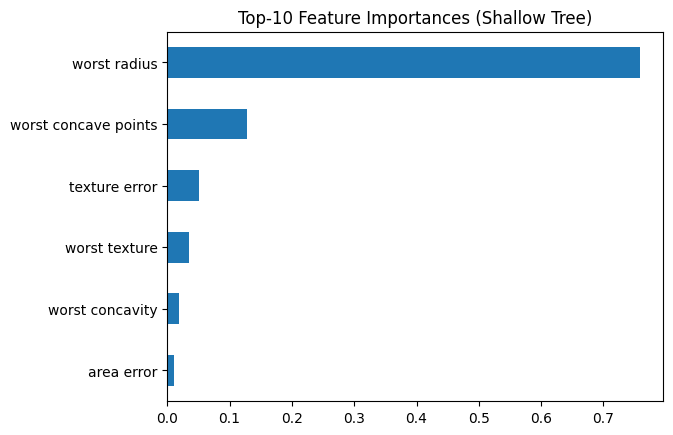

In [19]:
imp.head(6).sort_values().plot(kind="barh")
plt.title("Top-10 Feature Importances (Shallow Tree)")
plt.show()


## overfittinge çözüm

### Mini deney

Öncelikle sadece max_depth ile oynadığımız küçük bir deney yapalım.

In [20]:
results = []

for depth in [None, 10, 7, 5, 4, 3, 2, 1]:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    _ = model.fit(X_train, y_train)
    
    tr = accuracy_score(y_train, model.predict(X_train))
    te = accuracy_score(y_test, model.predict(X_test))
    fark = tr - te
    results.append((depth, tr, te, fark))

pd.DataFrame(results, columns=["max_depth", "train_acc", "test_acc","diff"])


,max_depth,train_acc,test_acc,diff
0,NaN,1.000000,0.923077,0.076923
1,10.0,1.000000,0.923077,0.076923
2,7.0,1.000000,0.923077,0.076923
3,5.0,0.995305,0.937063,0.058242
4,4.0,0.988263,0.944056,0.044207
5,3.0,0.976526,0.944056,0.032470
6,2.0,0.957746,0.909091,0.048656
7,1.0,0.922535,0.923077,-0.000542


### Cross-Validation ile daha düzgün değerlendirme

Tek split’e mahkum kalmayalım

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = DecisionTreeClassifier(max_depth=3, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring="f1")
scores.mean(), scores.std()


(np.float64(0.9400013128071114), np.float64(0.017084375453767054))

### GridSearch

In [22]:
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10, 20],
    "criterion": ["gini", "entropy"]
}

gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation

({'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 5,
  'min_samples_split': 20},
 np.float64(0.9531882303424789))

In [23]:
best_tree = gs.best_estimator_

pred_te = best_tree.predict(X_test)
proba_te = best_tree.predict_proba(X_test)[:, 1]

clf_metrics(y_test, pred_te, proba_te)


accuracy     0.951049
precision    0.946237
recall       0.977778
f1           0.961749
roc_auc      0.961635
dtype: float64

### post-pruning

In [24]:
tmp_tree = DecisionTreeClassifier(random_state=42)
path = tmp_tree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

len(ccp_alphas)
ccp_alphas[:5]
ccp_alphas[-5:]


13

array([0.        , 0.00231936, 0.00312989, 0.00422535, 0.00456509])

array([0.00814228, 0.01487676, 0.02166662, 0.05466684, 0.32538187])

In [25]:
trees = []
for a in ccp_alphas:
    t = DecisionTreeClassifier(random_state=42, ccp_alpha=a)
    _ = t.fit(X_train, y_train)
    trees.append(t)

# CV ile en iyi alpha
alpha_scores = []
for t in trees:
    scores = cross_val_score(t, X_train, y_train, cv=cv, scoring="f1")
    alpha_scores.append(scores.mean())

best_idx = int(np.argmax(alpha_scores))
best_alpha = ccp_alphas[best_idx]
best_alpha, alpha_scores[best_idx]


(np.float64(0.014876760563380283), np.float64(0.9490038440317946))

In [26]:
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

pred_te = pruned_tree.predict(X_test)
proba_te = pruned_tree.predict_proba(X_test)[:, 1]

clf_metrics(y_test, pred_te, proba_te)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

accuracy     0.909091
precision    0.963855
recall       0.888889
f1           0.924855
roc_auc      0.938155
dtype: float64

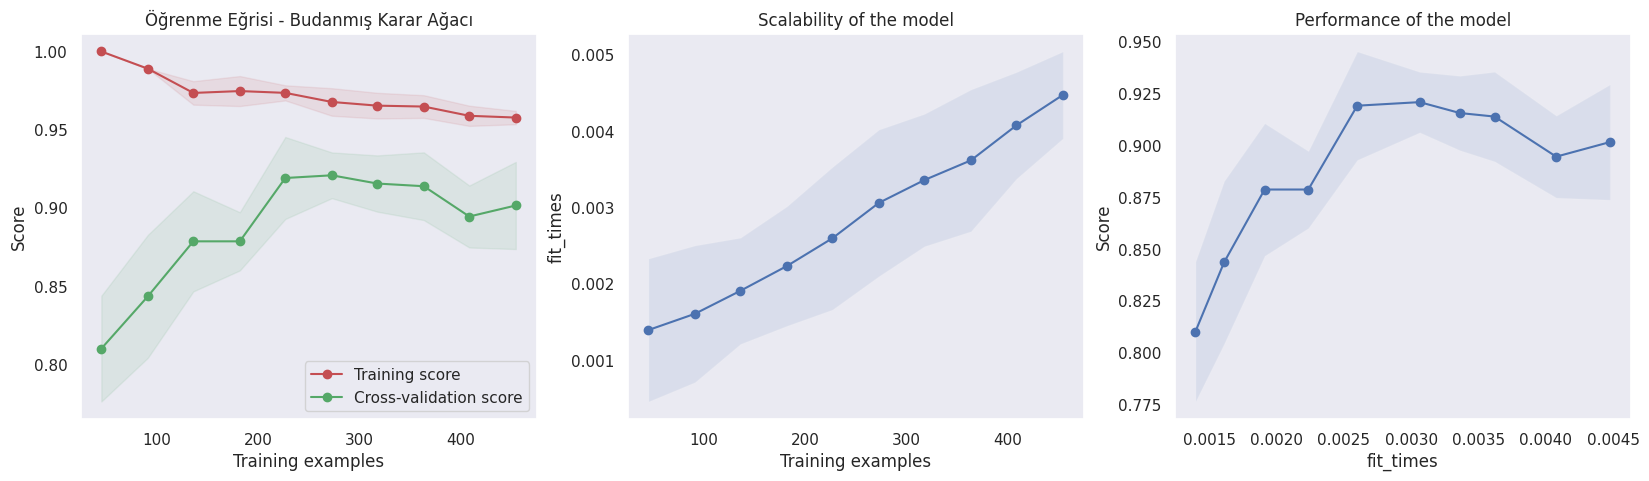

In [45]:
ml.plot_learning_curve(
    pruned_tree,
    "Öğrenme Eğrisi - Budanmış Karar Ağacı",
    X,
    y,
    cv=cv,
    train_sizes=np.linspace(0.1, 1.0, 10)
)